In [1]:
from enum import Enum
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
import random

### 1. Implement the lion and cow example on a 10x10 grid (the lion's starting position is at the bottom left square, and the cow is in the top right square). 

In [2]:
def GridState(x, y):
    return (x, y)

cow_init_state = GridState(0, 9)
lion_init_state = GridState(9, 0)

In [3]:
class Action(Enum):
    UP = 0
    DOWN = 1
    LEFT = 2
    RIGHT = 3

In [4]:
reward_partial = {
    (GridState(0, 8), Action.RIGHT) : 100, 
    (GridState(1, 9), Action.UP) : 100}
reward = defaultdict(int, reward_partial)    

In [5]:
width = 10
height = 10

def State(x, y):
    return (x, y)
states = [State(x, y) for x in range(width) for y in range(height)]

In [6]:
actions = {}
for s in states:
    actions[s] = []
    if s[0] > 0:
        actions[s].append(Action.UP)
    if s[0] < 9:
        actions[s].append(Action.DOWN)
    if s[1] > 0:
        actions[s].append(Action.LEFT)
    if s[1] < 9:
        actions[s].append(Action.RIGHT)

In [7]:
def get_move(s, a):
    return {
        Action.UP : (s[0] - 1, s[1]),
        Action.DOWN : (s[0] + 1, s[1]),
        Action.LEFT : (s[0], s[1] - 1),
        Action.RIGHT : (s[0], s[1] + 1)
    }[a]

def move(cell, direction, width=10, height=10):
    next_cell = get_move(cell, direction)
    if next_cell[0] in range(0, width) and next_cell[1] in range(0, height):
        return next_cell
    return cell

In [8]:
transitions = {(s, a) : move(s, a) for s in states for a in actions[s]}
for a in actions[cow_init_state]:
    transitions[cow_init_state, a] = cow_init_state

In [9]:
class MDP:
    def __init__(self, states, transitions, actions, reward):
        self.states = states
        self.transitions = transitions
        self.actions = actions
        self.reward = reward

### 2. Implement and apply policy iteration to that domain. How many iterations are needed? Experiment with the threshold for the policy 

In [145]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

In [154]:
def initalize_policy(mdp):
    values = {}
    policy = {}
    policy_prob = {}
    for s in mdp.states:
        values[s] = 1
        policy[s] = random.choice(mdp.actions[s])
        good_act = actions[s]
        for a in good_act: 
            policy_prob[(s, a)] = 1 / len(good_act)
    return values, policy, policy_prob

def policy_evaluation(mdp, values, policy_prob, gamma, theta, eval_iter):
    while True:
        eval_iter += 1
        delta = 0
        for s in mdp.states:
            v = values[s]
            values[s] = sum([policy_prob[(s, a)] * (r + gamma * values[ss]) 
                             for a in mdp.actions[s] 
                             for ss in [mdp.transitions[(s, a)]] for r in [mdp.reward[(s, a)]]])
            delta = max(delta, abs(v - values[s]))
        if delta < theta:
            return eval_iter, values
    
def policy_iteration(mdp, theta, gamma):
    random.seed(42)
    values, policy, policy_prob = initalize_policy(mdp)
    
    improv_iter = 0
    eval_iter = 0
    policy_stable = False
    while not policy_stable:
        eval_iter, values = policy_evaluation(mdp, values, policy_prob, gamma, theta, eval_iter)
        
        improv_iter += 1
        policy_stable = True
        for s in mdp.states:
            old_action = policy[s]
            candidates = [r + gamma * values[ss] for a in mdp.actions[s] 
                          for ss in [mdp.transitions[(s, a)]] for r in [mdp.reward[(s, a)]]]
            maxi = np.argmax(candidates)
            policy[s] = mdp.actions[s][maxi]
                    
            for i, a in enumerate(mdp.actions[s]):
                sm = softmax(candidates)
                policy_prob[(s, a)] = sm[i]
            
            if old_action != policy[s]:
                policy_stable = False
            
    print("Evaluations iterations", eval_iter)
    print("Improvement iterations:", improv_iter)
    return values, policy

In [151]:
def plot_policy(policy_vals):
    skeys = sorted(policy_vals.keys())
    x = np.array([a for a, _ in skeys])
    y = np.array([b for _, b in skeys])

    temp = np.array([policy_vals[k] for k in skeys])

    nrows, ncols = 10, 10
    grid = temp.reshape((nrows, ncols))

    plt.imshow(grid, extent=(x.min(), x.max(), y.max(), y.min()), cmap=cm.Greys)
    plt.show()

In [152]:
mdp = MDP(states, transitions, actions, reward)

Evaluations iterations 155
Improvement iterations: 22


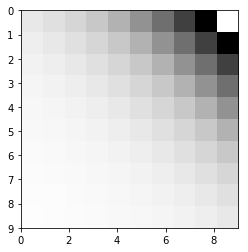

In [155]:
policy_vals, _ = policy_iteration(mdp, theta=0.0001, gamma=0.8)
plot_policy(policy_vals)

Evaluations iterations 243
Improvement iterations: 19


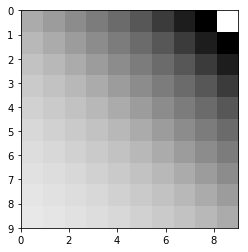

In [156]:
policy_vals, _ = policy_iteration(mdp, theta=0.000001, gamma=0.9)
plot_policy(policy_vals)

Evaluations iterations 19
Improvement iterations: 14


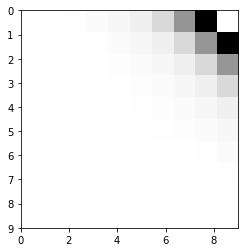

In [157]:
policy_vals, _ = policy_iteration(mdp, theta=7, gamma=0.5)
plot_policy(policy_vals)

### 3. Implement and apply value iteration to that domain. How many iterations are needed for convergence? 

In [103]:
def value_iteration(mdp, gamma, theta):
    values = {}
    for s in mdp.states:
        values[s] = 1
    niter = 0
    while True:
        niter += 1
        delta = 0
        for state in mdp.states:
            v = values[state]
            candidates = [r + gamma * values[ss]
                          for a in mdp.actions[state] 
                          for ss in [transitions[(state, a)]] for r in [reward[(state, a)]]]
            values[state] = max(candidates)
            delta = max(delta, abs(v - values[state]))
        if delta < theta:
            print("Number of iterations", niter)
            return values

Number of iterations 15


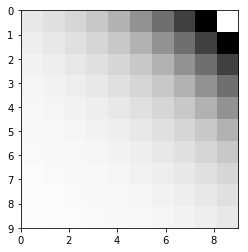

In [131]:
policy_vals = value_iteration(mdp, theta=0.01, gamma=0.8)
plot_policy(policy_vals)

Number of iterations 10


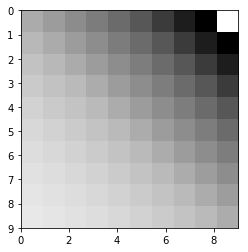

In [121]:
policy_vals = value_iteration(mdp, theta=10, gamma=0.9)
plot_policy(policy_vals)

Number of iterations 7


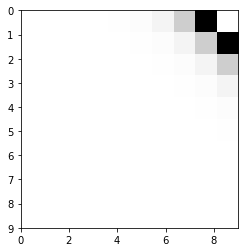

In [128]:
policy_vals = value_iteration(mdp, theta=0.1, gamma=0.3)
plot_policy(policy_vals)